In [1]:
# Load composite stack.
from skimage.io import imread
compositeStack = imread('/home/jiongyi/Documents/profilin-pulse-chase/2018-07-26-A488-maleimide-A647-nhs-actin-profilin-chase-2-gallery-composite.tiff')

In [2]:
noImages, noChannels, m, n = compositeStack.shape
# Split by channel.
a647Stack = compositeStack[0:noImages:2, 1, :, :]
a488Stack = compositeStack[1:noImages:2, 0, :, :]

In [3]:
# Binarize by otsu threshold
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from numpy import zeros
noImages, m, n = a647Stack.shape
bw647Stack = zeros((noImages, m, n), dtype = bool)
bw488Stack = zeros((noImages, m, n), dtype = bool)
for i in range(noImages):
    clahe647Image = equalize_adapthist(a647Stack[i, :, :])
    bw647Stack[i, :, :] = clahe647Image > threshold_otsu(clahe647Image)
    clahe488Image = equalize_adapthist(a488Stack[i, :, :])
    bw488Stack[i, :, :] = clahe488Image > threshold_otsu(clahe488Image)

In [4]:
# Calculate mean intensities.
from skimage.measure import label, regionprops
from numpy import mean
mean488IntensityList = []
mean647IntensityList = []
meanPulseIntensityList = []
a488AreaList = []
a647AreaList = []
for i in range(noImages):
    currentProperties = regionprops(label(bw647Stack[i, :, :]), a647Stack[i, :, :])
    mean647BackgroundIntensity = mean(a647Stack[i, :, :][~bw647Stack[i, :, :]].flatten())
    print(mean647BackgroundIntensity)
    for j in currentProperties:
        mean647IntensityList.append(j.mean_intensity - mean647BackgroundIntensity)
        a647AreaList.append(j.area)
    currentProperties = regionprops(label(bw488Stack[i, :, :]), a488Stack[i, :, :])
    otherChannelProperties = regionprops(label(bw488Stack[i, :, :]), a647Stack[i, :, :])
    mean488BackgroundIntensity = mean(a488Stack[i, :, :][~bw488Stack[i, :, :]].flatten())
    for j in currentProperties:
        mean488IntensityList.append(j.mean_intensity - mean488BackgroundIntensity)
        meanPulseIntensityList.append(mean(a647Stack[i, :, :][j.coords].flatten()) - mean647BackgroundIntensity)
        a488AreaList.append(j.area)

4105.904694772372
3458.414053093286
3660.1822321471145
3832.0297148608133
3537.967093545925


In [5]:
# Throw out objects that are too small
from numpy import array
areaThreshold = 15
is488AreaValidArray = array([x > areaThreshold for x in a488AreaList])
is647AreaValidArray = array([x > areaThreshold for x in a647AreaList])
a488AreaArray = array(a488AreaList)[is488AreaValidArray]
a647AreaArray = array(a647AreaList)[is647AreaValidArray]
mean488IntensityArray = array(mean488IntensityList)[is488AreaValidArray]
mean647IntensityArray = array(mean647IntensityList)[is647AreaValidArray]
meanPulseIntensityArray = array(meanPulseIntensityList)[is488AreaValidArray]

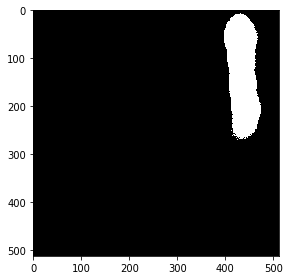

In [10]:
from skimage.io import imshow
imshow(bw647Stack[4, :, :])

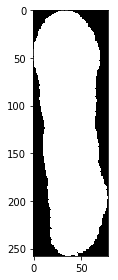

In [127]:
from skimage.morphology import skeletonize
from skimage.morphology import opening, square
properties = regionprops(label(opening(bw647Stack[4, :, :], square(3))), a647Stack[4, :, :])

/home/jiongyi/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


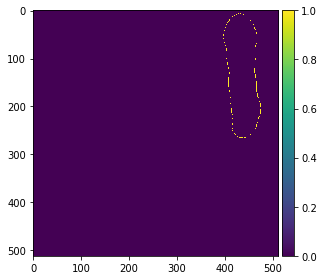

In [129]:
from skimage.segmentation import find_boundaries
skeletonImg = skeletonize(find_boundaries(opening(bw647Stack[4, :, :], square(3))))
skelPropertiesList = regionprops(label(skeletonImg))
snakeCoordsList = skelPropertiesList[0].coords
from numpy import flip
imshow(skeletonImg)

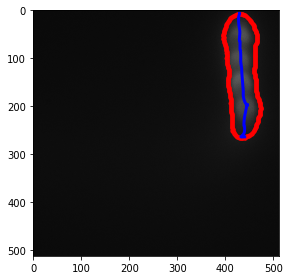

In [141]:
from skimage.segmentation import active_contour
% matplotlib inline
from matplotlib.pyplot import plot
contourCoordsArr = active_contour(equalize_adapthist(a647Stack[4, :, :]), flip(snakeCoordsList, axis = 1 ), beta = 0.4, bc = 'free')
imshow(a647Stack[4, :, :])
plot(snakeCoordsList[:, 1], snakeCoordsList[:, 0], '.r', linewidth = 3)
plot(contourCoordsArr[:, 0], contourCoordsArr[:, 1], '-b', linewidth = 3)

In [136]:
help(active_contour)

Help on function active_contour in module skimage.segmentation.active_contour_model:

active_contour(image, snake, alpha=0.01, beta=0.1, w_line=0, w_edge=1, gamma=0.01, bc='periodic', max_px_move=1.0, max_iterations=2500, convergence=0.1)
    Active contour model.
    
    Active contours by fitting snakes to features of images. Supports single
    and multichannel 2D images. Snakes can be periodic (for segmentation) or
    have fixed and/or free ends.
    The output snake has the same length as the input boundary.
    As the number of points is constant, make sure that the initial snake
    has enough points to capture the details of the final contour.
    
    Parameters
    ----------
    image : (N, M) or (N, M, 3) ndarray
        Input image.
    snake : (N, 2) ndarray
        Initialisation coordinates of snake. For periodic snakes, it should
        not include duplicate endpoints.
    alpha : float, optional
        Snake length shape parameter. Higher values makes snake contra